In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from typing import List, Tuple

import pathlib
import datetime
import time
AUTOTUNE = tf.data.AUTOTUNE

from tf_augmentation import ds_augment
from get_model import *

In [2]:
data_dir = pathlib.Path("C:/Users/AORUS/dataset")

In [3]:
REPEAT_TIMES = 20
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 64
IMG_SIZE = 96
EPOCHS = 10

In [4]:
train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
val_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(f"num: {num_classes}")
train_ds_ = train_ds.cache(str(data_dir / "train_ds")).unbatch().repeat(REPEAT_TIMES).shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=True)
val_ds_ = val_ds.cache(str(data_dir / "val_ds")).unbatch().repeat(max(1, REPEAT_TIMES // 4)).shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=True)

train_ds = ds_augment(train_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = ds_augment(val_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Found 2369 files belonging to 15 classes.
Found 2369 files belonging to 15 classes.
['apple', 'banana', 'bus', 'car', 'cat', 'cow', 'dog', 'durian', 'grape', 'horse', 'orange', 'pig', 'plane', 'ship', 'train']
num: 15


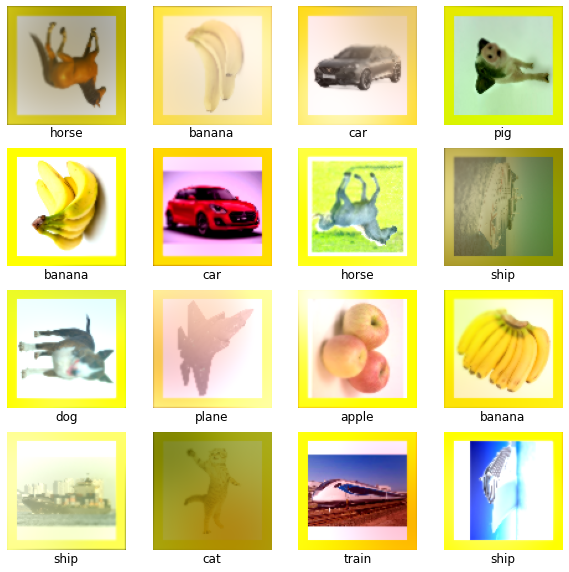

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255)
        plt.title(class_names[labels[i]], y=-0.15)
        plt.axis("off")

In [6]:
model = get_EfficientNetV2B0(IMG_SIZE, num_classes)
model.summary()

Model: "EfficientNetV2B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 predictions (Dense)         (None, 15)                19215     
                                                                 
Total params: 5,938,527
Trainable params: 5,877,91

In [7]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [11]:
export_path = f"D:/SmartCar/TFLite_Smartcar/saved_models/{int(time.time())}"
print(export_path)

'D:/SmartCar/TFLite_Smartcar/saved_models/1644237444'

In [9]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=export_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
)

history = model.fit(
    train_ds,
    # initial_epoch=50,
    epochs=5,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/5
    741/Unknown - 76s 88ms/step - loss: 1.7867 - accuracy: 0.3926INFO:tensorflow:Assets written to: D:/SmartCar/TFLite_Smartcar/saved_models\1644237444\assets
741/741 [==============================] - 120s 148ms/step - loss: 1.7867 - accuracy: 0.3926 - val_loss: 1.2318 - val_accuracy: 0.5804
Epoch 2/5
741/741 [==============================] - 158s 212ms/step - loss: 0.9043 - accuracy: 0.6914 - val_loss: 0.5726 - val_accuracy: 0.8092
Epoch 3/5
741/741 [==============================] - 214s 288ms/step - loss: 0.4715 - accuracy: 0.8437 - val_loss: 0.4163 - val_accuracy: 0.8630
Epoch 4/5
741/741 [==============================] - 236s 319ms/step - loss: 0.2966 - accuracy: 0.9011 - val_loss: 0.3381 - val_accuracy: 0.8940
Epoch 5/5
741/741 [==============================] - 199s 268ms/step - loss: 0.2223 - accuracy: 0.9276 - val_loss: 0.1623 - val_accuracy: 0.9474


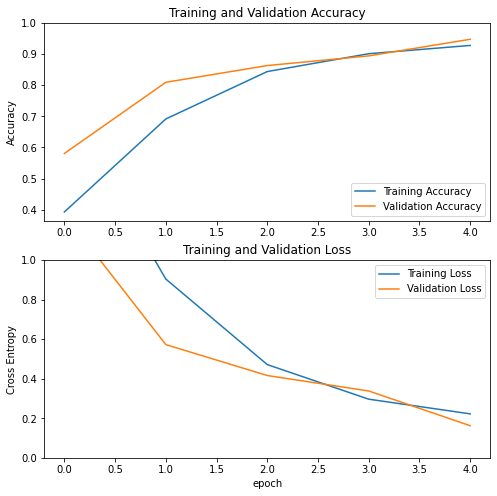

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()